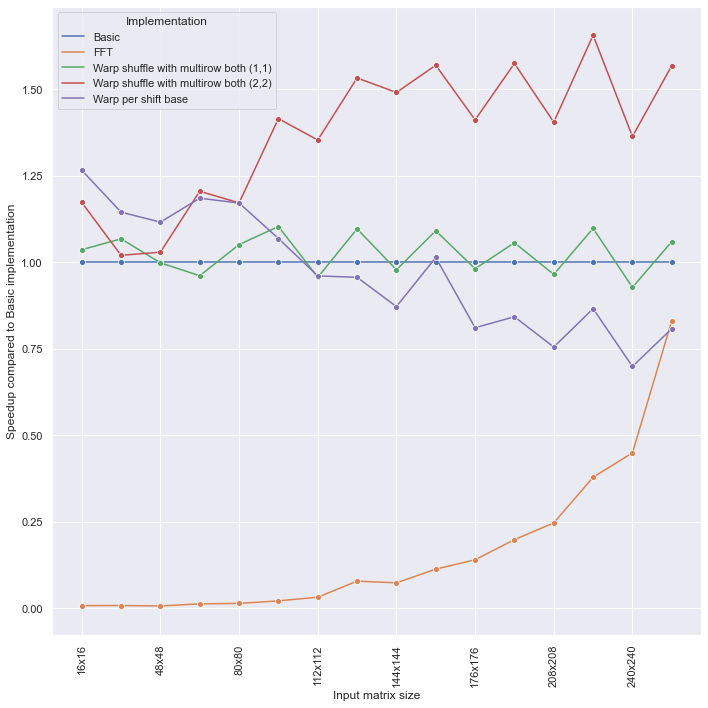

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark

from pathlib import Path

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "example" / "results")

group = benchmark.groups["one_to_one"]

comparison_base_name = "basic"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    "basic": {
        "": "Basic",
    },
    "fft_orig": {
        "": "FFT",
    },
    "nai_shuffle_multirow_both": {
        # "4": "Multirow right with 4 overlaps",
        # "8": "Multirow right with 8 overlaps",
        "1_1": "Warp shuffle with multirow both (1,1)",
        "2_2": "Warp shuffle with multirow both (2,2)",
    },
    "nai_warp_per_shift": {
        "": "Warp per shift base"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Computation time"].item()
    return min_time / row["Computation time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique()[::2])
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
fig.savefig("example_benchmark_results.svg", format="svg")